In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc
import os

In [2]:
import tqdm

In [3]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [4]:
import hapaseg.NB_coverage_MCMC as nb_cov

Load MCMC trace over SNP DP cluster assignments. Still looking at only the high purity exome

In [5]:
colors = mpl.cm.get_cmap("tab10").colors

### Load coverage

In [6]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [7]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [8]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [9]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [10]:
clust["snps_to_clusters"].shape

(500, 11768)

In [11]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single DP iteration

In [12]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [13]:
import scipy.stats

In [14]:
assgn_entropy = scipy.stats.entropy(Cov_clust_probs_overlap, axis=1)

(array([8.077e+03, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.600e+01,
        6.600e+01, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

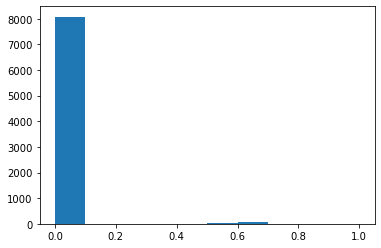

In [15]:
plt.hist(scipy.stats.entropy(Cov_clust_probs_overlap, axis=1), bins = np.r_[0:1.1:0.1], density=False)

almost all bins are unanimously assigned

In [16]:
entropy_idx = (assgn_entropy == 0)

In [17]:
#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

In [18]:
#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

In [19]:
Cov_overlap = Cov_overlap.iloc[~naidx]

In [20]:
Cov_overlap

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z
99,1,984246,984439,72279,110383,984246,984439,194,1.079453,1.880682,0.685567,0.269813
135,1,1138970,1139348,185857,281995,1138970,1139348,379,0.909914,0.588950,0.704485,0.291114
142,1,1147321,1147518,78285,120449,1147321,1147518,198,0.909914,0.588950,0.707071,0.293980
344,1,1469305,1469452,36846,57636,1469305,1469452,148,0.870065,0.250387,0.668919,0.250576
514,1,1956956,1957177,69400,108383,1956956,1957177,222,1.002400,1.320789,0.621622,0.193192
...,...,...,...,...,...,...,...,...,...,...,...,...
196523,22,50986595,50988380,977681,1456772,2880715315,2880717100,1786,0.954171,0.948001,0.693729,0.279074
196531,22,51009803,51009968,59148,93244,2880738523,2880738688,166,1.022385,1.470038,0.602410,0.168626
196560,22,51042269,51043492,635932,981591,2880770989,2880772212,1224,1.060847,1.749233,0.744281,0.334114
196569,22,51064006,51064109,40385,64456,2880792726,2880792829,104,1.060847,1.749233,0.576923,0.134799


In [21]:
mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

In [22]:
Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

In [23]:
C[:,:1][:,None].shape

(8044, 1, 1)

In [24]:
mcmc_C = mcmc_cov.Cov_MCMC(r, C, Pi, Cov_overlap)

In [25]:
mcmc_C.NR_simp()

In [26]:
mu_0 = mcmc_C.mu.copy()[0]
beta_0 = mcmc_C.beta.copy()

## Defining Optimization functions

In [469]:
mu = mcmc_C.mu.copy()
beta = mcmc_C.beta.copy()
epsi = np.ones((mu.shape)) *2

In [471]:
def gradmu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    tmp = ((Pi * exp) / (Pi@epsi + exp))
    out = (r*(Pi - tmp) - Pi@epsi * tmp).sum(0)
    return out

def gradbeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    tmp = ((C * exp) / (Pi@epsi + exp))
    out = (r*(C - tmp) - Pi@epsi * tmp).sum(0)
    return out

def gradepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    tmp = Pi / (Pi@epsi + exp)
    return (Pi * (ss.digamma(r + Pi@epsi) - ss.digamma(Pi@epsi)) \
            - r * tmp \
            + Pi * (np.log(Pi@epsi) - np.log(Pi@epsi + exp)) \
            + Pi@epsi * (Pi / (Pi@epsi) - tmp)).sum(0)

def hessmu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(r + Pi@epsi) * ((Pi@epsi + exp) * Pi **2 * exp - Pi**2 * exp**2) / (Pi@epsi + exp)**2).sum(0)

def hessbeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(r + Pi@epsi) * ((Pi@epsi + exp) * C **2 * exp - C**2 * exp**2) / (Pi@epsi + exp)**2).sum(0)

def hessepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    tmp = Pi / (Pi@epsi + exp)
    return (Pi**2 * (ss.polygamma(1, r +Pi@epsi) - ss.polygamma(1, r +Pi@epsi)) + r * Pi * (Pi / (Pi@epsi + exp)**2) + 2 * Pi * (Pi / (Pi@epsi) - tmp) + (Pi@epsi) * (Pi**2 / ((Pi@epsi + exp)**2) - Pi**2 / (Pi@epsi)**2)).sum(0)

def hessmubeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(r + Pi@epsi)[:,:,None] * ((Pi@epsi + exp)[:, :, None] * (Pi[:,:, None] * C[:, None, :] * exp[:, :, None]) - Pi[:,:, None] * C[:, None, :] * exp[:, :, None]**2) / ((Pi@epsi + exp)**2)[:,:, None]).sum(0)
    
def hessepsimu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return ((r * Pi**2 * exp) / (Pi@epsi + exp) **2 - Pi * (Pi * exp) / (Pi@epsi + exp)).sum(0)

def hessepsibeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return ((r[:,:,None] * Pi[:,:, None] * C[:, None, :] * exp[:,:,None]) / ((Pi@epsi + exp) **2)[:,:,None] -  Pi[:,:, None] * (C[:, None, :] * exp[:,:,None]) / (Pi@epsi + exp)[:,:,None]).sum(0)

In [496]:
def gradmu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    out = ((-Pi@epsi * (exp - Pi.T @r))/ (exp + Pi @epsi)).sum(0)
    return out

def gradbeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    tmp = ((C * exp) / (Pi@epsi + exp))
    out = (r*(C - tmp) - Pi@epsi * tmp).sum(0)
    return out

def gradepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    tmp = Pi / (Pi@epsi + exp)
    return (Pi * (ss.digamma(r + Pi@epsi) - ss.digamma(Pi@epsi)) \
            - r * tmp \
            + Pi * (np.log(Pi@epsi) - np.log(Pi@epsi + exp)) \
            + Pi@epsi * (Pi / (Pi@epsi) - tmp)).sum(0)

def hessmu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(r + Pi@epsi) * ((Pi@epsi + exp) * Pi **2 * exp - Pi**2 * exp**2) / (Pi@epsi + exp)**2).sum(0)

def hessbeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(r + Pi@epsi) * ((Pi@epsi + exp) * C **2 * exp - C**2 * exp**2) / (Pi@epsi + exp)**2).sum(0)

def hessepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    tmp = Pi / (Pi@epsi + exp)
    return (Pi**2 * (ss.polygamma(1, r +Pi@epsi) - ss.polygamma(1, r +Pi@epsi)) + r * Pi * (Pi / (Pi@epsi + exp)**2) + 2 * Pi * (Pi / (Pi@epsi) - tmp) + (Pi@epsi) * (Pi**2 / ((Pi@epsi + exp)**2) - Pi**2 / (Pi@epsi)**2)).sum(0)

def hessmubeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(r + Pi@epsi)[:,:,None] * ((Pi@epsi + exp)[:, :, None] * (Pi[:,:, None] * C[:, None, :] * exp[:, :, None]) - Pi[:,:, None] * C[:, None, :] * exp[:, :, None]**2) / ((Pi@epsi + exp)**2)[:,:, None]).sum(0)
    
def hessepsimu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return ((r * Pi**2 * exp) / (Pi@epsi + exp) **2 - Pi * (Pi * exp) / (Pi@epsi + exp)).sum(0)

def hessepsibeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(Pi@mu + C@beta)
    epsi = np.exp(lepsi)
    return ((r[:,:,None] * Pi[:,:, None] * C[:, None, :] * exp[:,:,None]) / ((Pi@epsi + exp) **2)[:,:,None] -  Pi[:,:, None] * (C[:, None, :] * exp[:,:,None]) / (Pi@epsi + exp)[:,:,None]).sum(0)

In [437]:
for i in range(100):
    print(mu)
    print(beta)
    print(epsi)
    gmu = gradmu(mu, beta, r, C, Pi, epsi)
    gbeta = gradbeta(mu, beta, r, C, Pi, epsi)
    gepsi = gradepsi(mu, beta, r, C, Pi, epsi)
    grad = np.r_[gmu, gbeta, gepsi * np.exp(epsi[:,0]) + 1]

    hmu = hessmu(mu, beta, r, C, Pi, epsi)
    hbeta = hessbeta(mu, beta, r, C, Pi, epsi)
    hmubeta = hessmubeta(mu, beta, r, C, Pi, epsi)
    hepsi = hessepsi(mu, beta, r, C, Pi, epsi) * np.exp(epsi[:,0] * 2) + np.exp(epsi[:,0]) * gepsi
    hepsimu = hessepsimu(mu, beta, r, C, Pi, epsi) * np.exp(epsi[:,0])
    hepsibeta = hessepsibeta(mu, beta, r, C, Pi, epsi) * np.exp(epsi)
    H = np.r_[np.r_[np.c_[np.diag(hmu), hmubeta, np.diag(hepsimu)]],
      np.r_[np.c_[hmubeta.T, np.diag(hbeta), hepsibeta.T]],
      np.r_[np.c_[np.diag(hepsimu), hepsibeta, np.diag(hepsi)]]]

    delta = np.linalg.inv(H)@grad
    mu[:,0] -= delta[0:len(mu)]
    beta[:,0] -= delta[len(mu):(len(mu) + len(beta))]
    epsi[:,0] -= delta[(len(mu) + len(beta)):]
    print(scipy.stats.nbinom.logpmf(r, Pi@np.exp(epsi), 1-(np.exp(Pi@mu + C @ beta) / (np.exp(Pi@mu + C @ beta) + np.exp(Pi@epsi)))).sum())
    if np.linalg.norm(grad) < 1e-5:
        break

[[5.23644377]
 [5.13132642]
 [5.0663258 ]
 [5.02498808]
 [5.2582049 ]
 [5.11905805]
 [5.44432759]
 [5.35820907]
 [5.22164532]
 [4.84635582]
 [4.55046023]
 [4.9723667 ]
 [5.1473075 ]
 [5.11030866]
 [5.04460314]
 [5.14848045]
 [5.31944667]
 [5.35782173]
 [5.62622168]]
[[1.09176716]
 [0.00315397]
 [1.43474052]]
[[1.95816105]
 [2.01375972]
 [2.23625863]
 [1.95432991]
 [1.96383425]
 [1.96984584]
 [1.95797892]
 [1.96200407]
 [1.9645937 ]
 [1.98787165]
 [2.11060811]
 [1.95570799]
 [1.9553699 ]
 [1.92085909]
 [1.92420518]
 [1.9517242 ]
 [1.95060493]
 [1.97650183]
 [1.94969636]]
-91719.01395432497
[[5.25968328]
 [5.15680826]
 [5.06226965]
 [5.04784141]
 [5.28554801]
 [5.14165746]
 [5.47005076]
 [5.38177167]
 [5.24307603]
 [4.86662414]
 [4.59308226]
 [4.99523895]
 [5.17199827]
 [5.1241238 ]
 [5.08228719]
 [5.1737581 ]
 [5.34305148]
 [5.38472343]
 [5.65959349]]
[[1.08865414]
 [0.00333824]
 [1.34574219]]
[[1.91389503]
 [2.03249173]
 [2.54901978]
 [1.90630184]
 [1.92569086]
 [1.93764539]
 [1.914375

/tmp/ipykernel_1120951/631788463.py:24: RuntimeWarning: overflow encountered in exp
  print(scipy.stats.nbinom.logpmf(r, Pi@np.exp(epsi), 1-(np.exp(Pi@mu + C @ beta) / (np.exp(Pi@mu + C @ beta) + np.exp(Pi@epsi)))).sum())
/tmp/ipykernel_1120951/631788463.py:24: RuntimeWarning: invalid value encountered in true_divide
  print(scipy.stats.nbinom.logpmf(r, Pi@np.exp(epsi), 1-(np.exp(Pi@mu + C @ beta) / (np.exp(Pi@mu + C @ beta) + np.exp(Pi@epsi)))).sum())
/tmp/ipykernel_1120951/2663041761.py:2: RuntimeWarning: overflow encountered in exp
  exp = np.exp(Pi@mu + C@beta)
/tmp/ipykernel_1120951/2663041761.py:4: RuntimeWarning: invalid value encountered in multiply
  tmp = ((Pi * exp) / (Pi@epsi + exp))
/tmp/ipykernel_1120951/2663041761.py:4: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((Pi * exp) / (Pi@epsi + exp))
/tmp/ipykernel_1120951/2663041761.py:9: RuntimeWarning: overflow encountered in exp
  exp = np.exp(Pi@mu + C@beta)
/tmp/ipykernel_1120951/2663041761.py:11: Run

nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [

In [448]:
(gepsi / hepsi).shape

(19, 19)

In [451]:
(gradepsi(mu, beta, r, C, Pi, epsi)* np.exp(epsi[:,0]) + 1).shape

(19,)

In [454]:
for i in range(100):
    print(mu)
    print(beta)
    print(epsi)
    
    for _ in range(10):
        gmu = gradmu(mu, beta, r, C, Pi, epsi)
        hmu = hessmu(mu, beta, r, C, Pi, epsi)
        mu_delta = gmu / hmu
        mu[:,0] -= mu_delta
        
    for _ in range(10):
        gbeta = gradbeta(mu, beta, r, C, Pi, epsi)
        hbeta = hessbeta(mu, beta, r, C, Pi, epsi)
        beta_delta = gbeta / hbeta
        beta[:,0] -= beta_delta
    
    for _ in range(10):
        gepsi = gradepsi(mu, beta, r, C, Pi, epsi)* np.exp(epsi[:,0]) + 1
        hepsi = hessepsi(mu, beta, r, C, Pi, epsi) * np.exp(epsi[:,0] * 2) + np.exp(epsi[:,0]) * gepsi
        epsi_delta = gepsi / hepsi
        epsi[:,0] -= epsi_delta

    print(scipy.stats.nbinom.logpmf(r, Pi@np.exp(epsi), 1-(np.exp(Pi@mu + C @ beta) / (np.exp(Pi@mu + C @ beta) + np.exp(Pi@epsi)))).sum())

[[5.2665679 ]
 [5.23081371]
 [4.79210436]
 [5.06376828]
 [5.27705514]
 [5.15111135]
 [5.48647066]
 [5.37381984]
 [5.26252682]
 [4.85810477]
 [4.63757415]
 [5.00952176]
 [5.19707935]
 [5.13171167]
 [4.9441077 ]
 [5.1760957 ]
 [5.34602393]
 [5.34110618]
 [5.6080107 ]]
[[1.08902692]
 [0.00737292]
 [1.51160723]]
[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]]
-516362.022540746
[[5.24405667]
 [5.14801101]
 [5.04820807]
 [5.03313226]
 [5.26292999]
 [5.12842716]
 [5.44962129]
 [5.36738281]
 [5.23255144]
 [4.85931045]
 [4.56176236]
 [4.98012161]
 [5.1551438 ]
 [5.13064544]
 [5.06978985]
 [5.15378245]
 [5.32562351]
 [5.36437787]
 [5.62526942]]
[[1.09217651]
 [0.01116798]
 [1.36202528]]
[[ 1.57764244]
 [ 2.31290863]
 [12.46092397]
 [ 1.5498831 ]
 [ 1.62484799]
 [ 1.67465377]
 [ 1.58275754]
 [ 1.60794077]
 [ 1.6334494 ]
 [ 1.84951695]
 [ 3.45348618]
 [ 1.55892097]
 [ 1.56035949]
 [ 1.2795466 ]
 [ 1.32743349]
 [ 1.52744914]
 [ 1.51

/tmp/ipykernel_1120951/2663041761.py:19: RuntimeWarning: invalid value encountered in multiply
  return (Pi * (ss.digamma(r + Pi@epsi) - ss.digamma(Pi@epsi)) \
/tmp/ipykernel_1120951/2663041761.py:21: RuntimeWarning: divide by zero encountered in log
  + Pi * (np.log(Pi@epsi) - np.log(Pi@epsi + exp)) \
/tmp/ipykernel_1120951/2663041761.py:21: RuntimeWarning: invalid value encountered in multiply
  + Pi * (np.log(Pi@epsi) - np.log(Pi@epsi + exp)) \
/tmp/ipykernel_1120951/2663041761.py:19: RuntimeWarning: invalid value encountered in add
  return (Pi * (ss.digamma(r + Pi@epsi) - ss.digamma(Pi@epsi)) \
/tmp/ipykernel_1120951/2663041761.py:22: RuntimeWarning: divide by zero encountered in true_divide
  + Pi@epsi * (Pi / (Pi@epsi) - tmp)).sum(0)
/tmp/ipykernel_1120951/2663041761.py:22: RuntimeWarning: invalid value encountered in true_divide
  + Pi@epsi * (Pi / (Pi@epsi) - tmp)).sum(0)
/tmp/ipykernel_1120951/2663041761.py:22: RuntimeWarning: invalid value encountered in multiply
  + Pi@epsi

nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [

### single cluster optimizers

In [27]:
mu = mu_0.copy()
epsi = 4

In [28]:
cl1_mask = Cov_overlap['cluster_assgn']==0
r = r[cl1_mask]
C = C[cl1_mask]
Pi = Pi[cl1_mask]
beta = beta_0.copy()

In [29]:
beta = beta_0.copy()

In [30]:
exp_0 = np.exp(mu_0 + C @ beta_0)

In [93]:
scipy.stats.nbinom.logpmf(r[:,0], np.exp(epsi), (1-(exp_0 / (exp_0 + np.exp(epsi))))[:,0]).sum()

-175362.39908231935

In [ ]:
ss.gammaln(r + epsi) - ss.gammaln(r + 1) - ss.gammaln(epsi)) * np.exp(r[0] * (np.log(exp_0)[0] - np.log(epsi + exp_0[0]))) * np.exp(epsi * np.log(epsi / (epsi + exp_0[0]))

In [145]:
p = (exp_0 / (exp_0 + epsi))[0]
np.log(np.exp(ss.gammaln(r + np.exp(epsi)) - ss.gammaln(r + 1) - ss.gammaln(np.exp(epsi))) * np.exp(r * (np.log(np.exp(mu + C @ beta)) - np.log(np.exp(epsi) + np.exp(mu + C @ beta)))) * np.exp(np.exp(epsi) * np.log(np.exp(epsi) / (np.exp(epsi) + np.exp(mu + C @ beta))))).sum(0)

array([-94719.30755521])

In [147]:
scipy.stats.nbinom.logpmf(r, np.exp(epsi), 1-(np.exp(mu + C @ beta) / (np.exp(mu + C @ beta) + np.exp(epsi)))).sum()

-94719.30755521558

In [95]:
scipy.stats.nbinom.pmf(r[0], epsi, 1-(exp_0[0] / (exp_0 + epsi)[0]))

array([1.10533389e-05])

In [1142]:
#fixing hessbeta
def gradmu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return ((epsi * (r - exp))/(epsi + exp)).sum(0)

def gradbeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return ((C * epsi * (r - exp)) / (exp + epsi)).sum(0)

def gradepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return (ss.digamma(r + epsi) - ss.digamma(epsi) + (exp - r + exp * np.log(epsi / (exp + epsi)) + epsi * np.log(epsi / (exp + epsi))) / (exp + epsi)).sum(0)

def hessmu(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(exp * epsi * (r + epsi)) / ((exp + epsi)**2)).sum(0)

def hessbeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return (-(C * epsi * (r + epsi) * exp) / ((exp + epsi)**2)).T@C

def hessepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return (ss.polygamma(1, r + epsi) - ss.polygamma(1, epsi) + (exp**2 + r * epsi)/ (epsi * (exp + epsi)**2)).sum(0)

def hessmubeta(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return ((-(C * epsi * (r + epsi) * exp)) / (exp + epsi)**2).sum(0)

def hessmuepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return ((exp * (r - exp)) / (exp + epsi)**2).sum(0)

def hessbetaepsi(mu, beta, r, C, Pi, lepsi):
    exp = np.exp(mu + C@beta)
    epsi = np.exp(lepsi)
    return ((C * exp * (r - exp)) / (exp + epsi)**2).sum(0)

In [1146]:
%%time
for i in range(100):
    gmu = gradmu(mu, beta, r, C, Pi, epsi)
    gbeta = gradbeta(mu, beta, r, C, Pi, epsi)
    gepsi = gradepsi(mu, beta, r, C, Pi, epsi)
    grad = np.r_[gmu, gbeta, gepsi * np.exp(epsi) + 1]

    hmu = hessmu(mu, beta, r, C, Pi, epsi)
    hbeta = hessbeta(mu, beta, r, C, Pi, epsi)
    hmubeta = hessmubeta(mu, beta, r, C, Pi, epsi)
    hepsi = hessepsi(mu, beta, r, C, Pi, epsi) * np.exp(2*epsi) + np.exp(epsi) * gepsi
    hmuepsi = hessmuepsi(mu, beta, r, C, Pi, epsi) * np.exp(epsi)
    hbetaepsi = hessbetaepsi(mu, beta, r, C, Pi, epsi) * np.exp(epsi)
    H = np.r_[np.c_[hmu[:,None], hmubeta[None,:], hmuepsi[:,None]],
              np.c_[hmubeta.T, hbeta, hbetaepsi.T],
              np.c_[hmuepsi[:,None], hbetaepsi[None,:], hepsi[:,None]]]

    delta = np.linalg.inv(H)@grad
    print(delta)
    print(mu)
    print(beta)
    print(epsi)
    print(scipy.stats.nbinom.logpmf(r[:,0], np.exp(epsi), (1-(np.exp(mu + C@beta) / (np.exp(mu + C@beta) + np.exp(epsi))))[:,0]).sum())
    mu -= delta[0]
    beta[:,0] -= delta[1:4]
    epsi -= delta[4:]
    print('gradnorm :', np.linalg.norm(grad))
    if np.linalg.norm(grad) < 1e-5:
        break

[ 0.10910671 -0.01916906 -0.00470703  0.08067447  0.61096375]
[5.2665679]
[[1.08902692]
 [0.00737292]
 [1.51160723]]
4
-8357.184448009051
gradnorm : 3556.7326659511464
[ 0.11715773 -0.02068091 -0.00493814  0.08580891  0.30764847]
[5.15746118]
[[1.10819598]
 [0.01207996]
 [1.43093277]]
[3.38903625]
-8081.833043281283
gradnorm : 1145.5004698772427
[ 0.04732861 -0.00842101 -0.0019111   0.03406346  0.07559167]
[5.04030345]
[[1.12887689]
 [0.01701809]
 [1.34512386]]
[3.08138779]
-8040.847040047744
gradnorm : 235.74444126172398
[ 0.00378197 -0.00068016 -0.00014378  0.00265682  0.00483091]
[4.99297484]
[[1.1372979 ]
 [0.01892919]
 [1.3110604 ]]
[3.00579612]
-8038.816965289447
gradnorm : 13.23428007058269
[ 1.81248281e-05 -3.30078042e-06 -6.41322209e-07  1.23773849e-05
  2.15504185e-05]
[4.98919288]
[[1.13797806]
 [0.01907297]
 [1.30840358]]
[3.00096521]
-8038.804127847094
gradnorm : 0.043662647314372346
[ 3.89934388e-10 -7.19660327e-11 -1.27727709e-11  2.58445374e-10
  4.48017204e-10]
[4.9891

In [954]:
from statsmodels.discrete.discrete_model import NegativeBinomial as NB

In [1107]:
C_ots = np.c_[np.ones((C.shape[0],1)), C]

In [1108]:
C_ots.shape

(718, 4)

In [1109]:
ots = NB(r[:,0], C_ots)

In [1110]:
%%time
res = ots.fit()

Optimization terminated successfully.
         Current function value: 11.196104
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
CPU times: user 41.9 ms, sys: 158 µs, total: 42.1 ms
Wall time: 20.8 ms


In [1111]:
res.params

array([4.98917362, 1.13798158, 0.01907387, 1.30838923, 0.04987643])

In [1112]:
ots.loglike(res.params)

-8038.8027374801595

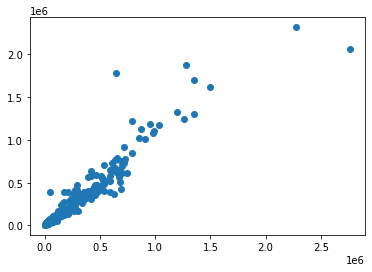

In [1113]:
plt.scatter(r, ots.predict(res.params, C_ots))

In [1030]:
np.log(1/0.04987643)

2.9982067325039363

In [1114]:
mu = np.array([4.98917362])
beta = np.array([1.13798158, 0.01907387, 1.30838923])[:,None]
epsi = np.array([np.log(1/0.04987643)])

In [1115]:
gmu = gradmu(mu, beta, r, C, Pi, epsi)
gbeta = gradbeta(mu, beta, r, C, Pi, epsi)
gepsi = gradepsi(mu, beta, r, C, Pi, epsi)
grad = np.r_[gmu, gbeta, gepsi * np.exp(epsi) + 1]

hmu = hessmu(mu, beta, r, C, Pi, epsi)
hbeta = hessbeta(mu, beta, r, C, Pi, epsi)
hmubeta = hessmubeta(mu, beta, r, C, Pi, epsi)
hepsi = hessepsi(mu, beta, r, C, Pi, epsi) * np.exp(2*epsi) + np.exp(epsi) * gepsi
hmuepsi = hessmuepsi(mu, beta, r, C, Pi, epsi) * np.exp(epsi)
hbetaepsi = hessbetaepsi(mu, beta, r, C, Pi, epsi) * np.exp(epsi)
H = np.r_[np.c_[hmu[:,None], hmubeta[None,:], hmuepsi[:,None]],
          np.c_[hmubeta.T, hbeta, hbetaepsi.T],
          np.c_[hmuepsi[:,None], hbetaepsi[None,:], hepsi[:,None]]]

In [1116]:
grad

array([ 8.77507572e-05, -1.60794587e-03, -2.38917361e-03,  3.36064876e-04,
        9.99423623e-01])

In [1119]:
H[1:4, 1:4]

array([[-5.16706339e+09, -1.89517948e+08, -8.48125267e+07],
       [-1.89517948e+08, -1.51220847e+08, -1.10467045e+07],
       [-8.48125267e+07, -1.10467045e+07, -3.73596639e+06]])

In [1100]:
hepsi

array([-364.67228293])

In [1101]:
np.linalg.inv(H)@grad

array([-7.69024045e-09,  3.71987624e-12,  3.00457158e-11, -2.69533018e-10,
       -2.74060758e-03])

In [1102]:
np.linalg.norm(grad)

0.9994278326925478

In [1104]:
np.linalg.det(-H)

7.460478169268353e+30

In [1105]:
scipy.stats.nbinom.logpmf(r[:,0], np.exp(epsi), (1-(np.exp(self.mu + self.C@self.beta) / (np.exp(mu + C@beta) + np.exp(epsi))))[:,0]).sum()

-8038.802737432865

In [1121]:
ots._hessian_nb2(res.params)[1:4,1:4]

array([[-4.38267580e+05, -1.86321642e+04, -6.30478804e+03],
       [-1.86321642e+04, -1.69022496e+04, -1.24843429e+03],
       [-6.30478804e+03, -1.24843429e+03, -4.25927996e+02]])